In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import copy

import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
import torch
import transformers
import baukit
from transformers import AutoModelForCausalLM, AutoTokenizer
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b-slimpj" # state-spaces/mamba-2.8b

mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

2024-03-19 17:16:52 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2024-03-19 17:16:52 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b-slimpj/resolve/main/config.json HTTP/1.1" 200 0
2024-03-19 17:17:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b-slimpj/resolve/main/pytorch_model.bin HTTP/1.1" 302 0


/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-03-19 17:17:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /EleutherAI/gpt-neox-20b/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-03-19 17:17:05 src.models INFO     loaded model <state-spaces/mamba-2.8b-slimpj> | size: 10560.400 MB | dtype: torch.float32 | device: cuda


In [8]:
# from src.data.dataclasses import CounterFactDataset

from src.dataset.dataclasses import load_relation
relation = load_relation(file = "../data/relation/factual/place_in_city.json")
relation.select_icl_examples(0)

2024-03-19 17:17:41 src.dataset.dataclasses INFO     initialized relation -> "place in city" with 154 samples


In [9]:
question, answer = relation[10]
print(question, end="\n\n")
print(f"{answer=}")


Sun Temple is located in the city of

answer='Konark'


In [10]:
from src.functional import filter_samples_by_model_knowledge
relation = filter_samples_by_model_knowledge(
    mt = mt,
    relation = relation,
)

2024-03-19 17:17:44 src.functional DEBUG    "place in city" | filtering with state-spaces/mamba-2.8b-slimpj


2024-03-19 17:17:44 src.functional DEBUG    sample.subject='Serengeti National Park' -> answer='Mara Region' | predicted = ' Ar'(0.318) ==> (✗)
2024-03-19 17:17:44 src.functional DEBUG    sample.subject='Yosemite National Park' -> answer='California' | predicted = ' Mar'(0.260) ==> (✗)
2024-03-19 17:17:44 src.functional DEBUG    sample.subject='Great Ocean Road' -> answer='Victoria' | predicted = ' Tor'(0.455) ==> (✗)
2024-03-19 17:17:44 src.functional DEBUG    sample.subject='Prague Castle' -> answer='Prague' | predicted = ' Prague'(0.901) ==> (✓)
2024-03-19 17:17:44 src.functional DEBUG    sample.subject='Empire State Building' -> answer='New York' | predicted = ' New'(0.907) ==> (✓)
2024-03-19 17:17:44 src.functional DEBUG    sample.subject='Prado Museum' -> answer='Madrid' | predicted = ' Madrid'(0.966) ==> (✓)
2024-03-19 17:17:44 src.functional DEBUG    sample.subject='SeaWorld Orlando' -> answer='Orlando' | predicted = ' Orlando'(0.972) ==> (✓)
2024-03-19 17:17:44 src.functional 

In [12]:
from src.tracing import calculate_average_indirect_effects
from src.plotting import plot_trace_heatmap

# -------------------------------------------------
n_trials = 30
# -------------------------------------------------

In [13]:
prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

aie = calculate_average_indirect_effects(
    mt = mt,
    prompt = prompt_template,
    samples = relation.samples,
    corruption_strategy="alt_patch",
    n_trials=n_trials,
    save_path=f"../results/causal_tracing/aie/block_state.json",
)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [28:14<00:00, 56.47s/it]


2024-03-19 17:46:22 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-19 17:46:22 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='nor

2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/comfortaa/Comfortaa-Regular.ttf', name='Comfortaa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/linux-libertine/LinLibertine_RZ.otf', name='Linux Libertine O', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-03-19 17:46:22 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/adf/GilliusADF-Italic.otf', name='Gillius ADF', style='italic', variant='normal', weight=400, str

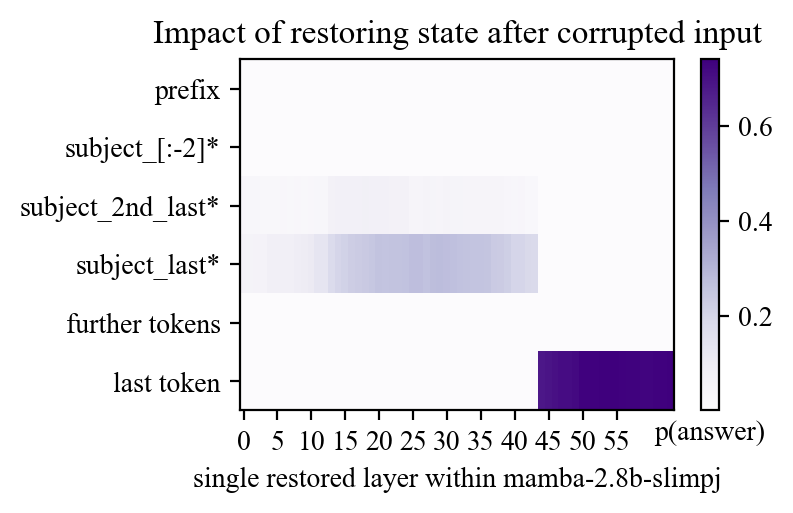

In [14]:
plot_trace_heatmap(aie, modelname = mt.name.split("/")[-1])

In [15]:
prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

hook = "mlp_after_silu"
aie = calculate_average_indirect_effects(
    mt = mt,
    prompt = prompt_template,
    samples = relation.samples,
    corruption_strategy="alt_patch",
    n_trials=n_trials,
    save_path=f"../results/causal_tracing/aie/{hook}.json",
    mamba_block_hook = hook
)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [45:32<00:00, 91.09s/it] 


2024-03-19 18:31:55 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f38a023d000>
2024-03-19 18:31:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-19 18:31:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-19 18:31:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-19 18:31:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


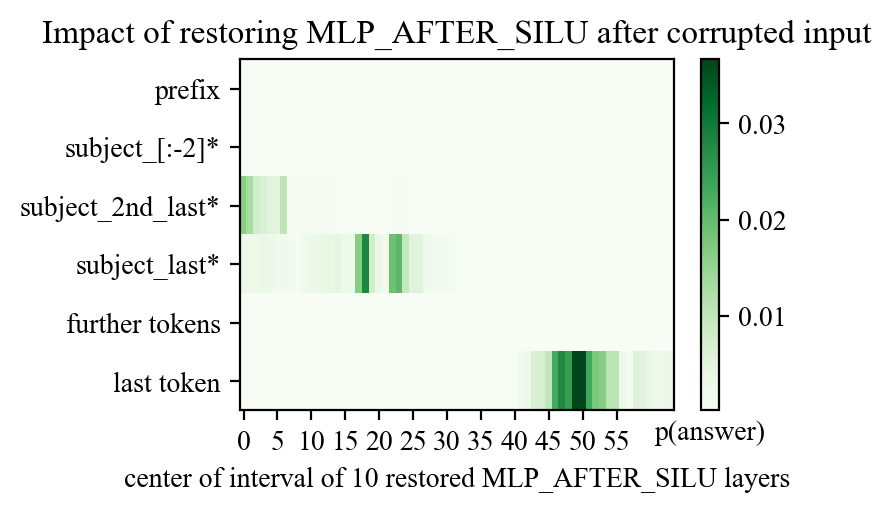

In [16]:
plot_trace_heatmap(aie, modelname = mt.name.split("/")[-1])

In [17]:
prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

hook = "ssm_after_ssm"
aie = calculate_average_indirect_effects(
    mt = mt,
    prompt = prompt_template,
    samples = relation.samples,
    corruption_strategy="alt_patch",
    n_trials=n_trials,
    save_path=f"../results/causal_tracing/aie/{hook}.json",
    mamba_block_hook = hook
)

 37%|███▋      | 11/30 [16:21<30:04, 94.96s/it] 

2024-03-14 18:01:45 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fba303d6bf0>
2024-03-14 18:01:45 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-14 18:01:45 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-14 18:01:45 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-14 18:01:45 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


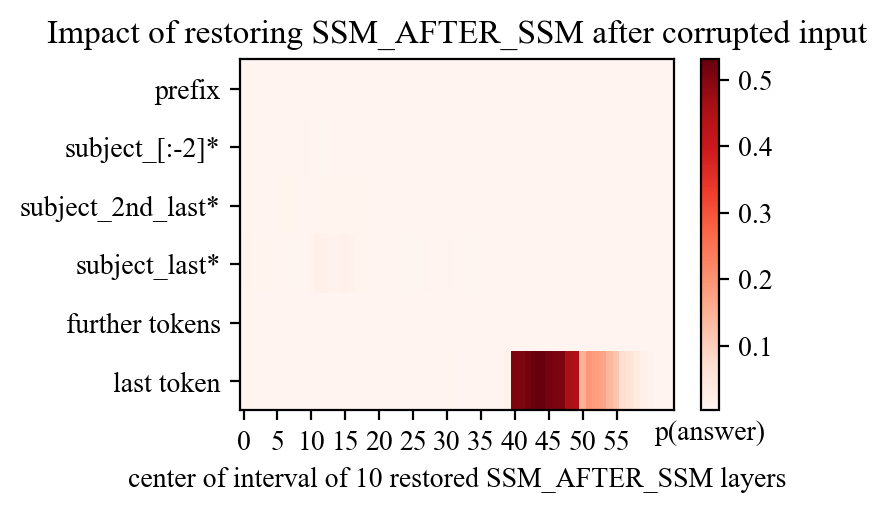

In [ ]:
plot_trace_heatmap(aie, modelname = mt.name.split("/")[-1])